### Table of contents
#### 1. Import libraries and data
#### 2. Data cleaning and wrangling 
#### 3. Time series decomposition
#### 4. Testing for stationarity

### 1. Import libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings


warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
path = r'/Users/jakubkondelka/Documents/JK_USkillings'

In [108]:
data = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'Homicides_cleaned.pkl'))

In [13]:
# check basics

data.head()

,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,...,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
0,1,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,...,Unknown,Male,15.0,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI
1,2,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,...,Unknown,Male,42.0,White,Unknown,Acquaintance,Strangulation,0,0,FBI
2,3,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,...,Unknown,Unknown,0.0,Unknown,Unknown,Unknown,Unknown,0,0,FBI
3,4,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,...,Unknown,Male,42.0,White,Unknown,Acquaintance,Strangulation,0,0,FBI
4,5,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,...,Unknown,Unknown,0.0,Unknown,Unknown,Unknown,Unknown,0,1,FBI


In [14]:
data.describe()

,Record ID,Year,Incident,Victim Age,Perpetrator Age,Victim Count,Perpetrator Count
count,638453.000000,638453.000000,638453.000000,638453.000000,638453.000000,638453.000000,638453.000000
mean,319227.005932,1995.801074,22.967797,35.033495,20.322697,0.123334,0.185224
std,184305.660258,9.927675,92.149837,41.628336,17.886842,0.537734,0.585496
min,1.000000,1980.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,159614.000000,1987.000000,1.000000,22.000000,0.000000,0.000000,0.000000
50%,319227.000000,1995.000000,2.000000,30.000000,21.000000,0.000000,0.000000
75%,478840.000000,2004.000000,10.000000,42.000000,31.000000,0.000000,0.000000
max,638454.000000,2014.000000,999.000000,998.000000,99.000000,10.000000,10.000000


### 2. Data cleaning and wrangling

<AxesSubplot:xlabel='Victim Count', ylabel='Count'>

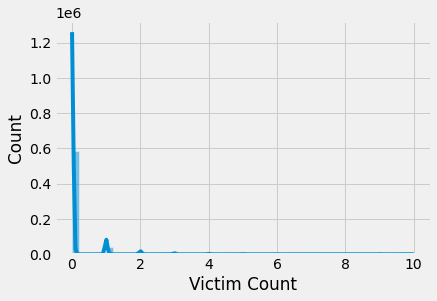

In [94]:
# check Victim Count column for any extreme values
sns.histplot(data['Victim Count'], bins=50, kde = True) # shows extreme values for 'Victim Count'

In [95]:
# the Victim Count > 0 represents additional victims. I will replace every value of 0 by value of 1, so that will give me the actual number of victims for those crimes
data.loc[data['Victim Count'] == 0, 'Victim Count'] = 1



<AxesSubplot:xlabel='Victim Count', ylabel='Count'>

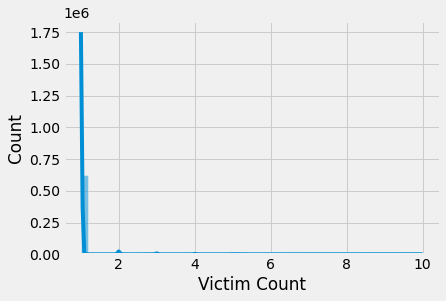

In [96]:
sns.histplot(data['Victim Count'], bins=50, kde = True) # shows extreme values for 'Victim Count'

#### For our analysis, we will use a subset with two columns - Year and Victim Count. This simply represents number of victims across the US in any given year

In [97]:
# create a data set for our analysis - containing columns Year and Victim Count. 

data_sub = data[['Year', 'Victim Count']]

In [98]:
data_sub.head()

,Year,Victim Count
0,1980,1
1,1980,1
2,1980,1
3,1980,1
4,1980,1


In [75]:
data_sub.shape

(638453, 2)

In [109]:
data_sub.groupby('Year').agg({'Victim Count': ['sum']})

,Victim Count
,sum
Year,
1980,23934
1981,21917
1982,21710
1983,20264
1984,18969
1985,19013
1986,20793
1987,19486


In [110]:
# add the SUM column
data_times2 = data_sub.assign(SUM=data_sub.groupby('Year').transform('sum'))


In [111]:
data_times2

,Year,Victim Count,SUM
0,1980,1,23934
1,1980,1,23934
2,1980,1,23934
3,1980,1,23934
4,1980,1,23934
...,...,...,...
638449,2014,1,15068
638450,2014,1,15068
638451,2014,1,15068
638452,2014,1,15068


In [112]:
# Drop Victim Count column
data_times2 = data_times2.drop(columns = ['Victim Count'])

In [113]:
data_times2

,Year,SUM
0,1980,23934
1,1980,23934
2,1980,23934
3,1980,23934
4,1980,23934
...,...,...
638449,2014,15068
638450,2014,15068
638451,2014,15068
638452,2014,15068


In [114]:
# remove duplicates 
data_times = data_times2.drop_duplicates(keep='first')

In [115]:
data_times

,Year,SUM
0,1980,23934
23092,1981,21917
44300,1982,21710
64844,1983,20264
84497,1984,18969
102590,1985,19013
120976,1986,20793
141101,1987,19486
159884,1988,19398
178663,1989,20533


In [116]:
# Export daba to pkl
data_times.to_pickle(os.path.join(path, '02 Data','Prepared Data', 'data_times.pkl'))

In [121]:
data_times.dtypes

Year    int64
SUM     int64
dtype: object

In [122]:
# replace Florida's 8mil of homicides with 301 948
data_times.loc[data_times['Year'] == 1980, 'Year2'] = '1980-01-01'
data_times.loc[data_times['Year'] == 1981, 'Year2'] = '1981-01-01'
data_times.loc[data_times['Year'] == 1982, 'Year2'] = '1982-01-01'
data_times.loc[data_times['Year'] == 1983, 'Year2'] = '1983-01-01'
data_times.loc[data_times['Year'] == 1984, 'Year2'] = '1984-01-01'
data_times.loc[data_times['Year'] == 1985, 'Year2'] = '1985-01-01'
data_times.loc[data_times['Year'] == 1986, 'Year2'] = '1986-01-01'
data_times.loc[data_times['Year'] == 1987, 'Year2'] = '1987-01-01'
data_times.loc[data_times['Year'] == 1988, 'Year2'] = '1988-01-01'
data_times.loc[data_times['Year'] == 1989, 'Year2'] = '1989-01-01'
data_times.loc[data_times['Year'] == 1990, 'Year2'] = '1990-01-01'
data_times.loc[data_times['Year'] == 1991, 'Year2'] = '1991-01-01'
data_times.loc[data_times['Year'] == 1992, 'Year2'] = '1992-01-01'
data_times.loc[data_times['Year'] == 1993, 'Year2'] = '1993-01-01'
data_times.loc[data_times['Year'] == 1994, 'Year2'] = '1994-01-01'
data_times.loc[data_times['Year'] == 1995, 'Year2'] = '1995-01-01'
data_times.loc[data_times['Year'] == 1996, 'Year2'] = '1996-01-01'
data_times.loc[data_times['Year'] == 1997, 'Year2'] = '1997-01-01'
data_times.loc[data_times['Year'] == 1998, 'Year2'] = '1998-01-01'
data_times.loc[data_times['Year'] == 1999, 'Year2'] = '1999-01-01'
data_times.loc[data_times['Year'] == 2000, 'Year2'] = '2000-01-01'
data_times.loc[data_times['Year'] == 2001, 'Year2'] = '2001-01-01'
data_times.loc[data_times['Year'] == 2002, 'Year2'] = '2002-01-01'
data_times.loc[data_times['Year'] == 2003, 'Year2'] = '2003-01-01'
data_times.loc[data_times['Year'] == 2004, 'Year2'] = '2004-01-01'
data_times.loc[data_times['Year'] == 2005, 'Year2'] = '2005-01-01'
data_times.loc[data_times['Year'] == 2006, 'Year2'] = '2006-01-01'
data_times.loc[data_times['Year'] == 2007, 'Year2'] = '2007-01-01'
data_times.loc[data_times['Year'] == 2008, 'Year2'] = '2008-01-01'
data_times.loc[data_times['Year'] == 2009, 'Year2'] = '2009-01-01'
data_times.loc[data_times['Year'] == 2010, 'Year2'] = '2010-01-01'
data_times.loc[data_times['Year'] == 2011, 'Year2'] = '2011-01-01'
data_times.loc[data_times['Year'] == 2012, 'Year2'] = '2012-01-01'
data_times.loc[data_times['Year'] == 2013, 'Year2'] = '2013-01-01'
data_times.loc[data_times['Year'] == 2014, 'Year2'] = '2014-01-01'



In [124]:
data_times

,Year,SUM,Year2
0,1980,23934,1980-01-01
23092,1981,21917,1981-01-01
44300,1982,21710,1982-01-01
64844,1983,20264,1983-01-01
84497,1984,18969,1984-01-01
102590,1985,19013,1985-01-01
120976,1986,20793,1986-01-01
141101,1987,19486,1987-01-01
159884,1988,19398,1988-01-01
178663,1989,20533,1989-01-01


In [126]:
# Export daba to pkl
data_times.to_pickle(os.path.join(path, '02 Data','Prepared Data', 'data_times2.pkl'))

In [127]:
# Drop Year column
data_times.drop(['Year'], axis=1, inplace=True)

In [128]:
data_times

,SUM,Year2
0,23934,1980-01-01
23092,21917,1981-01-01
44300,21710,1982-01-01
64844,20264,1983-01-01
84497,18969,1984-01-01
102590,19013,1985-01-01
120976,20793,1986-01-01
141101,19486,1987-01-01
159884,19398,1988-01-01
178663,20533,1989-01-01


In [130]:
# Set the "Year2" column as the index

from datetime import datetime

data_times['date'] = pd.to_datetime(data_times['Year2']) # Create a datetime column from "Date.""
data_times = data_times.set_index('date') # Set the datetime as the index of the dataframe.
data_times.drop(['Year2'], axis=1, inplace=True) # Drop the "Date" column.
data_times.head()

,SUM
date,
1980-01-01,23934
1981-01-01,21917
1982-01-01,21710
1983-01-01,20264
1984-01-01,18969


In [131]:
# Export daba to pkl
data_times.to_pickle(os.path.join(path, '02 Data','Prepared Data', 'datetime.pkl'))

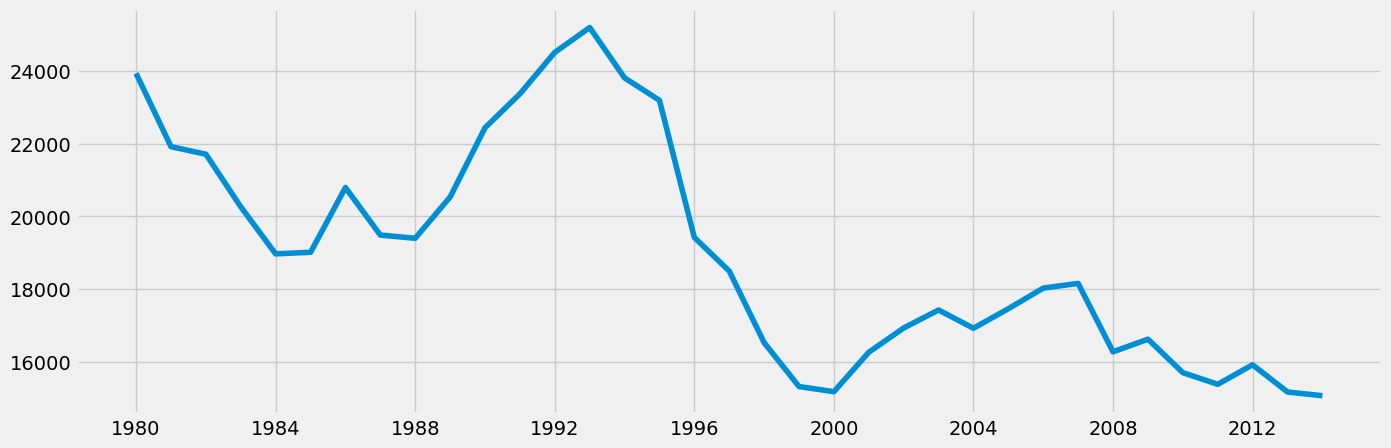

In [132]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_times)

In [133]:
# Check for missing values

data_sub.isnull().sum() 

Year            0
Victim Count    0
dtype: int64

In [134]:
# Check for duplicates

dups = data_times.duplicated()
dups.sum()

0

### 3. Time series decomposition

In [135]:
# we will decompose the time series using and additive style of decomposition


decomposition = sm.tsa.seasonal_decompose(data_times, model='additive')

In [136]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

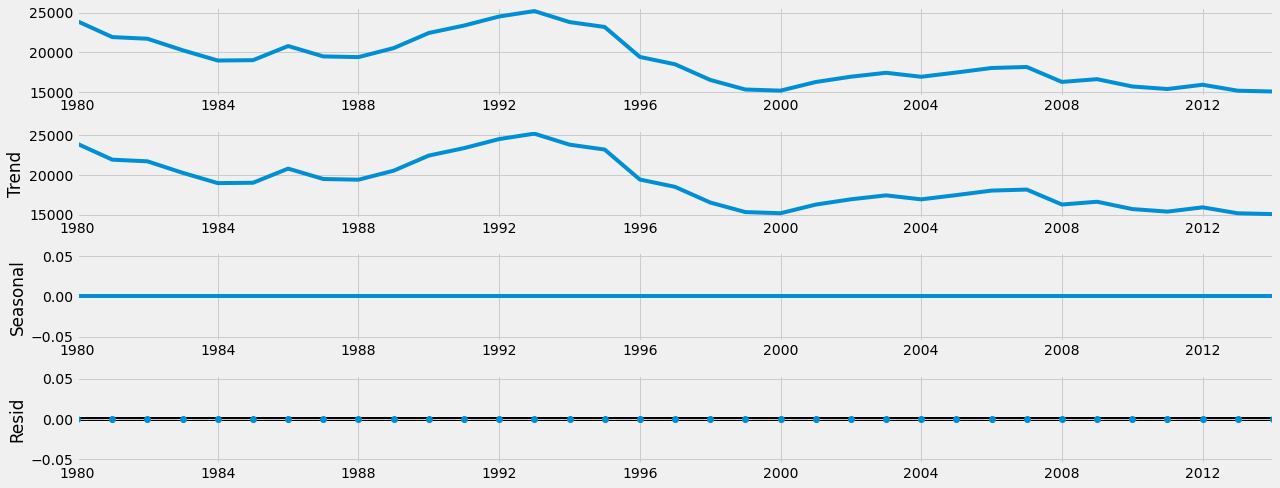

In [137]:
# Plot the separate components

decomposition.plot()
plt.show()

#### At first look, there is no seasonality in this data set. This is not strange, as homicides do not follow any seasonal pattern. There is a slight downward trend

### 4. Testing for stationarity

In [141]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_times['SUM'])

Dickey-Fuller Stationarity test:
Test Statistic                 -1.868429
p-value                         0.347056
Number of Lags Used             2.000000
Number of Observations Used    32.000000
Critical Value (1%)            -3.653520
Critical Value (5%)            -2.957219
Critical Value (10%)           -2.617588
dtype: float64


#### p value is 0.34 , that is too large. We are looking for a value < 0.05. Test statistic is bigger than Critical Value 5%. The null hypothesis (presence of unit root) can't be rejected. This requires smooting and running test again

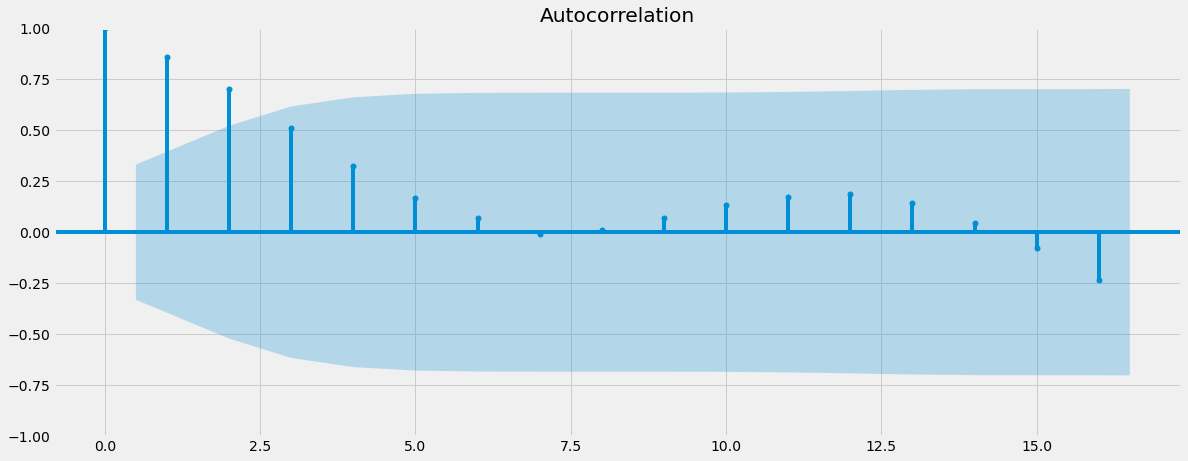

In [142]:
# Check for autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

plot_acf(data_times)
plt.show()

#### This looks better, as there are not that many (3) lines above the blue area. This indicates a very few auto-correlations. We will run Dickey-Fuller test one more time, in order to make data even more stationary

In [143]:
# running the Dickey-Fuller test again

data_times2 = data_times - data_times.shift(1)

In [144]:
data_times2.dropna(inplace = True)

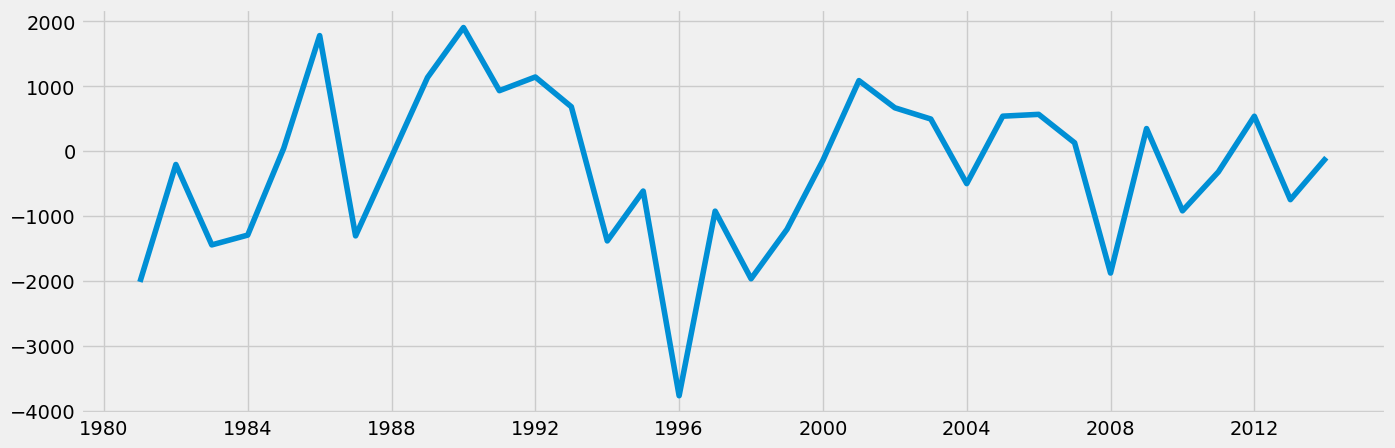

In [145]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_times2)

In [146]:
dickey_fuller(data_times2)

Dickey-Fuller Stationarity test:
Test Statistic                 -3.127770
p-value                         0.024565
Number of Lags Used             4.000000
Number of Observations Used    29.000000
Critical Value (1%)            -3.679060
Critical Value (5%)            -2.967882
Critical Value (10%)           -2.623158
dtype: float64


#### this time, the test statistic is smaller than Critical value (5%), so this points to data being stationary. p-value is also < than 0.05

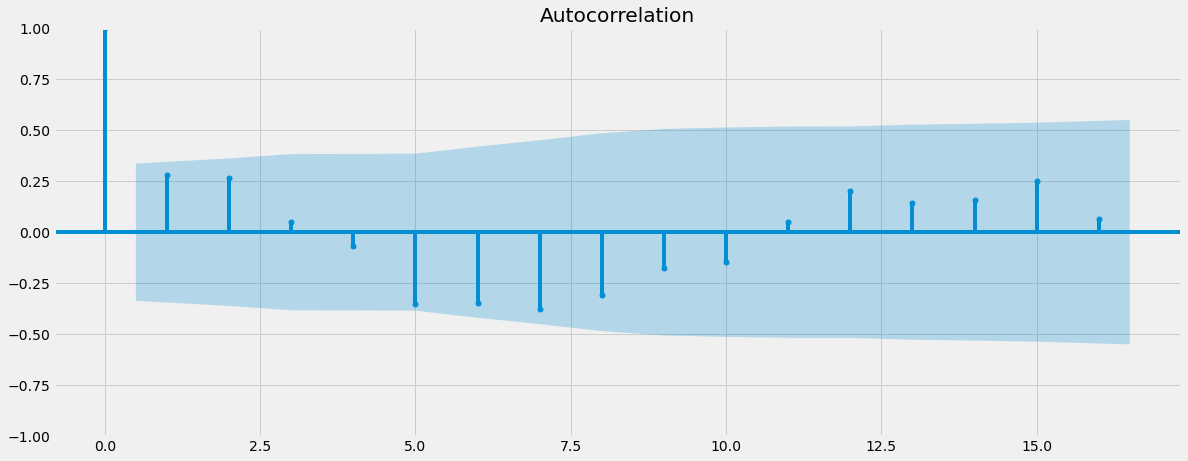

In [147]:
# run autocorrelation again

plot_acf(data_times2)
plt.show()

#### now the data shows almost no auto correlation

In [148]:
# Export daba to pkl
data_times2.to_pickle(os.path.join(path, '02 Data','Prepared Data', 'datetime_stationary.pkl'))